## 타임시리즈
# 주가 분석 : batch normalization 적용(2)
- https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS (삼성전자)
- https://finance.yahoo.com/quote/%5EKS11/history?p=%5EKS11 (KOSPI)
- https://finance.yahoo.com/quote/035420.KS/history?p=035420.KS (Naver)

- https://m.blog.naver.com/tkdlqm2/221575377059
- https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
stock_df = pd.read_csv('samsung_005930.KS.csv')
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-08-25,24620.0,24620.0,24420.0,24560.0,66.414185,11577200.0
1,2014-08-26,24700.0,24700.0,24420.0,24440.0,66.089699,10719450.0
2,2014-08-27,24460.0,24740.0,24440.0,24600.0,66.522362,12171000.0
3,2014-08-28,25160.0,25160.0,24720.0,24840.0,67.171364,10311850.0
4,2014-08-29,24760.0,24760.0,24560.0,24680.0,66.738708,14558250.0


In [3]:
stock_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1220,2019-08-16,43800.0,43900.0,43300.0,43900.0,43900.0,9528115.0
1221,2019-08-19,44350.0,44350.0,43500.0,43600.0,43600.0,6014218.0
1222,2019-08-20,43950.0,44600.0,43550.0,44450.0,44450.0,8434205.0
1223,2019-08-21,44350.0,44800.0,44150.0,44500.0,44500.0,6571717.0
1224,2019-08-22,44500.0,44700.0,43850.0,44050.0,44050.0,8061177.0


In [4]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 7 columns):
Date         1225 non-null object
Open         1224 non-null float64
High         1224 non-null float64
Low          1224 non-null float64
Close        1224 non-null float64
Adj Close    1224 non-null float64
Volume       1224 non-null float64
dtypes: float64(6), object(1)
memory usage: 67.1+ KB


In [5]:
stock_df = stock_df.dropna() # 2019.8.2 데이터가 비어있음

In [6]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224 entries, 0 to 1224
Data columns (total 7 columns):
Date         1224 non-null object
Open         1224 non-null float64
High         1224 non-null float64
Low          1224 non-null float64
Close        1224 non-null float64
Adj Close    1224 non-null float64
Volume       1224 non-null float64
dtypes: float64(6), object(1)
memory usage: 76.5+ KB


In [7]:
stock_df['average'] = (stock_df['High'] + stock_df['Low'])/2

In [8]:
stock_df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,average
0,2014-08-25,24620.0,24620.0,24420.0,24560.0,66.414185,11577200.0,24520.0
1,2014-08-26,24700.0,24700.0,24420.0,24440.0,66.089699,10719450.0,24560.0


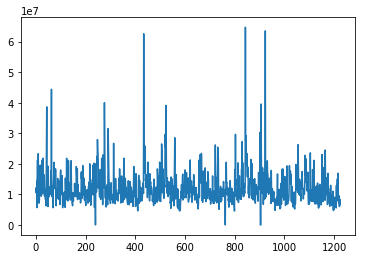

In [9]:
plt.plot(stock_df['Volume'])
#plt.ylim(0,1000000)

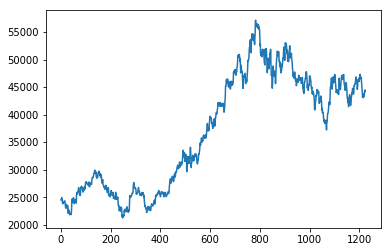

In [10]:
plt.plot(stock_df['average'])

- 거래량과 일별평균주가로 데이터를 만든다

In [11]:
stock = stock_df[['Volume','average']].values
stock.shape

(1224, 2)

### 정규화 (속성별 평균 0, 표준편차 1)

In [13]:
stock = (stock - stock.min(axis=0)) / (stock.max(axis=0) - stock.min(axis=0))

In [14]:
stock[:2]

array([[0.17898836, 0.0913649 ],
       [0.16572719, 0.09247911]])

### 학습용 데이터 생성

In [17]:
stock.shape

(1224, 2)

In [18]:
lookback = 50 # 50일치 데이터로 시퀀스를 만든다

In [19]:
X = []
y = []

for i in range(len(stock)-lookback):
    X.append(stock[i:i+lookback])
    y.append(stock[i+lookback,[1]])

In [20]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1174, 50, 2), (1174, 1))

In [21]:
X_train = X[:-200-lookback]
X_test = X[-200:]
y_train = y[:-200-lookback]
y_test = y[-200:]

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((924, 50, 2), (200, 50, 2), (924, 1), (200, 1))

### 모델 생성

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
model = Sequential()

model.add(BatchNormalization(axis=1, input_shape=X_train.shape[1:]))
    # 배치에 대해 거래량과 평균주가별로 정규화

model.add(LSTM(32, return_sequences=True, activation='relu')) # ReLU 적용 (회귀)
model.add(LSTM(32, return_sequences=True, activation='relu')) # ReLU 적용 (회귀)
model.add(LSTM(32))

model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 50, 2)             200       
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 32)            4480      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,353
Trainable params: 21,253
Non-trainable params: 100
_________________________________________________________________


In [25]:
model.compile(loss='mse', optimizer='rmsprop', metrics=['acc'])

In [22]:
h = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=[X_test, y_test])

Train on 924 samples, validate on 200 samples
Epoch 1/200
924/924 [==============================] - 18s 19ms/step - loss: 0.0414 - acc: 0.0022 - val_loss: 0.0064 - val_acc: 0.0000e+00
Epoch 2/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0068 - acc: 0.0022 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 3/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0083 - acc: 0.0022 - val_loss: 0.0307 - val_acc: 0.0000e+00
Epoch 4/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0049 - acc: 0.0022 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 5/200
924/924 [==============================] - 7s 8ms/step - loss: 0.0040 - acc: 0.0022 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 6/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0043 - acc: 0.0022 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 7/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0041 - acc: 0.0022 - val_loss: 0.0053 - val_acc: 0.00

924/924 [==============================] - 7s 8ms/step - loss: 0.0018 - acc: 0.0022 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 61/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0014 - acc: 0.0022 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 62/200
924/924 [==============================] - 7s 8ms/step - loss: 0.0017 - acc: 0.0022 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 63/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0014 - acc: 0.0022 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 64/200
924/924 [==============================] - 7s 8ms/step - loss: 0.0015 - acc: 0.0022 - val_loss: 0.0190 - val_acc: 0.0000e+00
Epoch 65/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0019 - acc: 0.0022 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 66/200
924/924 [==============================] - 7s 7ms/step - loss: 0.0022 - acc: 0.0022 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 67/200
924/924 [=========================

924/924 [==============================] - 7s 7ms/step - loss: 6.1376e-04 - acc: 0.0022 - val_loss: 0.0164 - val_acc: 0.0000e+00
Epoch 177/200
924/924 [==============================] - 7s 8ms/step - loss: 7.1869e-04 - acc: 0.0022 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 178/200
924/924 [==============================] - 7s 7ms/step - loss: 6.7941e-04 - acc: 0.0022 - val_loss: 0.0146 - val_acc: 0.0000e+00
Epoch 179/200
924/924 [==============================] - 7s 7ms/step - loss: 7.4013e-04 - acc: 0.0022 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 180/200
924/924 [==============================] - 7s 7ms/step - loss: 7.2098e-04 - acc: 0.0022 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 181/200
924/924 [==============================] - 7s 7ms/step - loss: 8.1084e-04 - acc: 0.0022 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 182/200
924/924 [==============================] - 7s 7ms/step - loss: 6.5635e-04 - acc: 0.0022 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 183/200

### 평가

Text(0.5,1,'Samsung - Stock price')

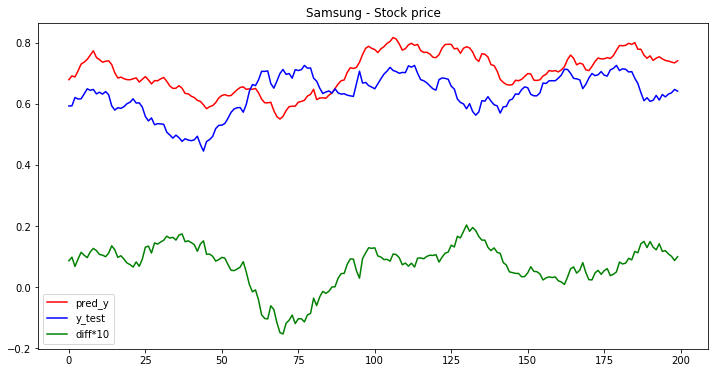

In [25]:
pred_y = model.predict(X_test)

plt.figure(figsize=[12,6])
plt.plot(pred_y.ravel(), 'r-', label='pred_y')
plt.plot(y_test.ravel(), 'b-', label='y_test')
plt.plot((pred_y-y_test).ravel(), 'g-', label='diff*10')
plt.legend()
plt.title('Samsung - Stock price')

Text(0.5,1,'Loss')

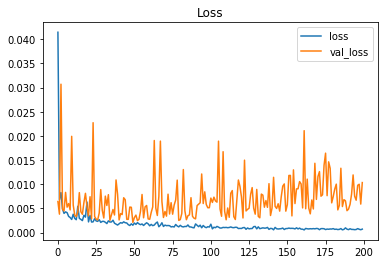

In [24]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')